## On the Prudential Life Insurance data set

In this notebook, we explore a little bit the Prudential Life Insurance data set, trying to predict the Response class of a customer (ranging between 1 and 8). Note that the quadratic weighted kappa is the metric used to evaluate the predictions, punishing large differences in prediction and truth (e.g. 1 predicted when actually class 8 is true).
This is the first time I wanted to use neural networks with keras, even if this seems not to be the right classifier. What we will do is the following:
- Exploring data a little bit
- Build pipelines
- Build a simple neural network at first start
- Depending on the confusion matrix, try differentiationg low classes (1-4) from higher classes
- Use it for a second output of our model so it first tries to separate lower from higher classes and then predict the actual class

As it turns out, the fourth point seems to be difficult and we will not achieve a competitive result.

### Getting the data

The next cell simply imports some fundamental modules we will use, sets random seeds and fetches the data from the local Kaggle folder. Note that, using !ls ../input/prudential-life-insurance-assessment, the data comes actually zipped though Kaggle shows csv files under the tab Data

In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
import keras


np.random.seed(43)
tf.random.set_seed(43)

# fetch the local data
#DATA_PATH = os.path.join('.','datasets','Prudential-Life-Insurance-Assessment')
#TRAIN_PATH = os.path.join(DATA_PATH,'train.csv')
#TEST_PATH = os.path.join(DATA_PATH,'test.csv')
#df_train = pd.read_csv(TRAIN_PATH)
#df_test = pd.read_csv(TEST_PATH)

# fetch the Kaggle data
DATA_PATH = os.path.join('..','input','prudential-life-insurance-assessment')
# strangely, using !ls ../input/prudential-life-insurance-assessment, the data is zipped
df_train = pd.read_csv(os.path.join(DATA_PATH,'train.csv.zip'))
df_test = pd.read_csv(os.path.join(DATA_PATH,'test.csv.zip'))

Using TensorFlow backend.


### Data Exploration

So here comes some standard data exploration. First check for missing values (and be sure they are really missing and not misunderstood by pd.reasd_csv, which by default takes NA as None (e.g. in housing pricing, NA means just not available...)

In [2]:
def uncompl_cols(df):
    """Takes a DataFrame and returns the columns which have at least one null-value,
    returning them as an pandas IndexObject"""
    return df.columns[df_train.isnull().any()]

def df_perc_mis_values(df):
    """returns a DataFrame with index being the columns with at least one null-value
    and computes the percentage of null-values"""
    dic = {}
    for col_name in uncompl_cols(df):
        dic[col_name] = df[col_name].isnull().sum() / len(df.index)
    return pd.DataFrame.from_dict(dic, orient = 'index', columns = ['perc of null'])
    
df_missing = df_perc_mis_values(df_train)
df_missing

,perc of null
Employment_Info_1,0.000320
Employment_Info_4,0.114161
Employment_Info_6,0.182786
Insurance_History_5,0.427679
Family_Hist_2,0.482579
Family_Hist_3,0.576632
Family_Hist_4,0.323066
Family_Hist_5,0.704114
Medical_History_1,0.149694
Medical_History_10,0.990620


There is in some categories missing a lot and I am not quite sure how to proceed with the missing data. Some columns are missing that much data that imputing values seems to be artificial and that we should drop the whole. We will decide later. According to the Prudential description, there are four main categories:
- categorical
- continuous
- discrete
- dummy

We will first sort out the different categories and then take a look on some diagrams:

In [3]:
# separate the column names

dummy_cols = list(df_train.filter(axis='columns', like='Medical_Keyword_').columns)
disc_cols = ['Medical_History_' + str(i) for i in [1,10,15,24,32]] # all have missing values!
cont_cols = ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_4',
             'Employment_Info_6', 'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3',
             'Family_Hist_4', 'Family_Hist_5']
cat_cols = list(df_train.drop(columns=['Response']+dummy_cols+disc_cols+cont_cols).columns)

print("""Numbers of dummy_cols, disc_cols, cont_cols, cat_cols equals number of columns of 
dataframe without label:""",
     len(dummy_cols+disc_cols+cont_cols+cat_cols) == len(df_train.drop(columns=['Response']).columns))

Numbers of dummy_cols, disc_cols, cont_cols, cat_cols equals number of columns of 
dataframe without label: True


Note that all columns of disc_cols have missing data (exactly where medical history misses data), and that all Family_History, Insurance_History as well as Employment_Info columns with missing data are in cont_cols.

#### Dummy columns

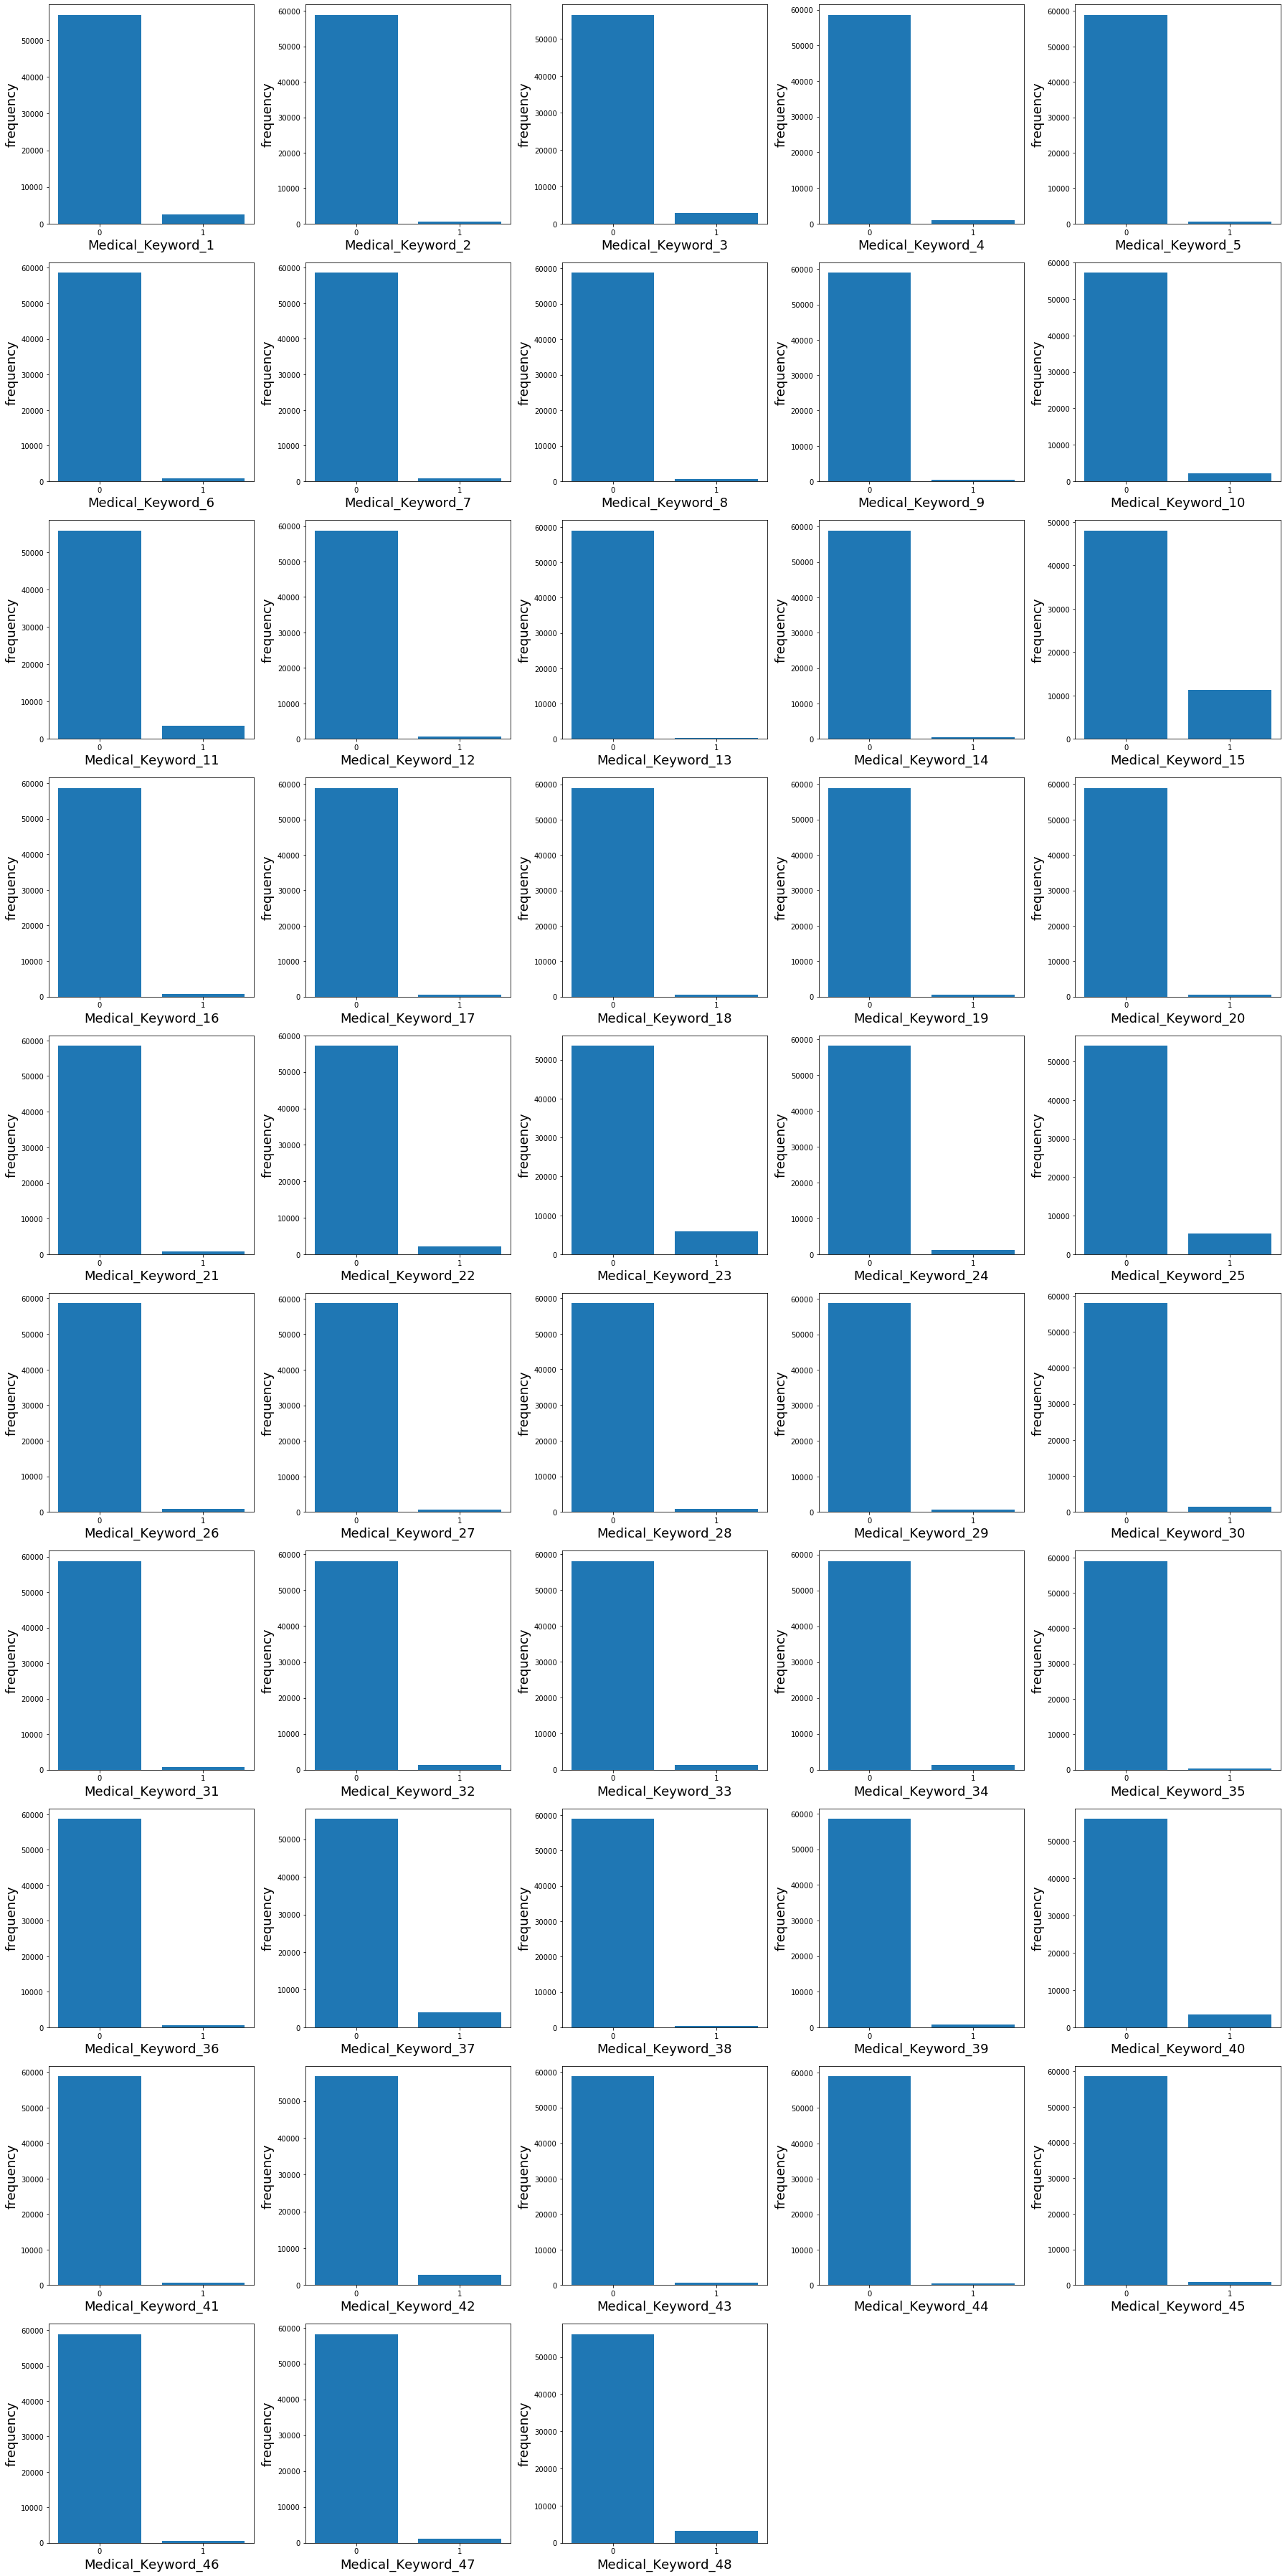

In [4]:
# look at the dummy variables
def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(range(len(keys)), vals, align="center")
        plt.xticks(range(len(keys)), keys)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()
    
plot_categoricals(df_train[dummy_cols])

Well, they are all binary with most values being zero.

#### Categorical columns

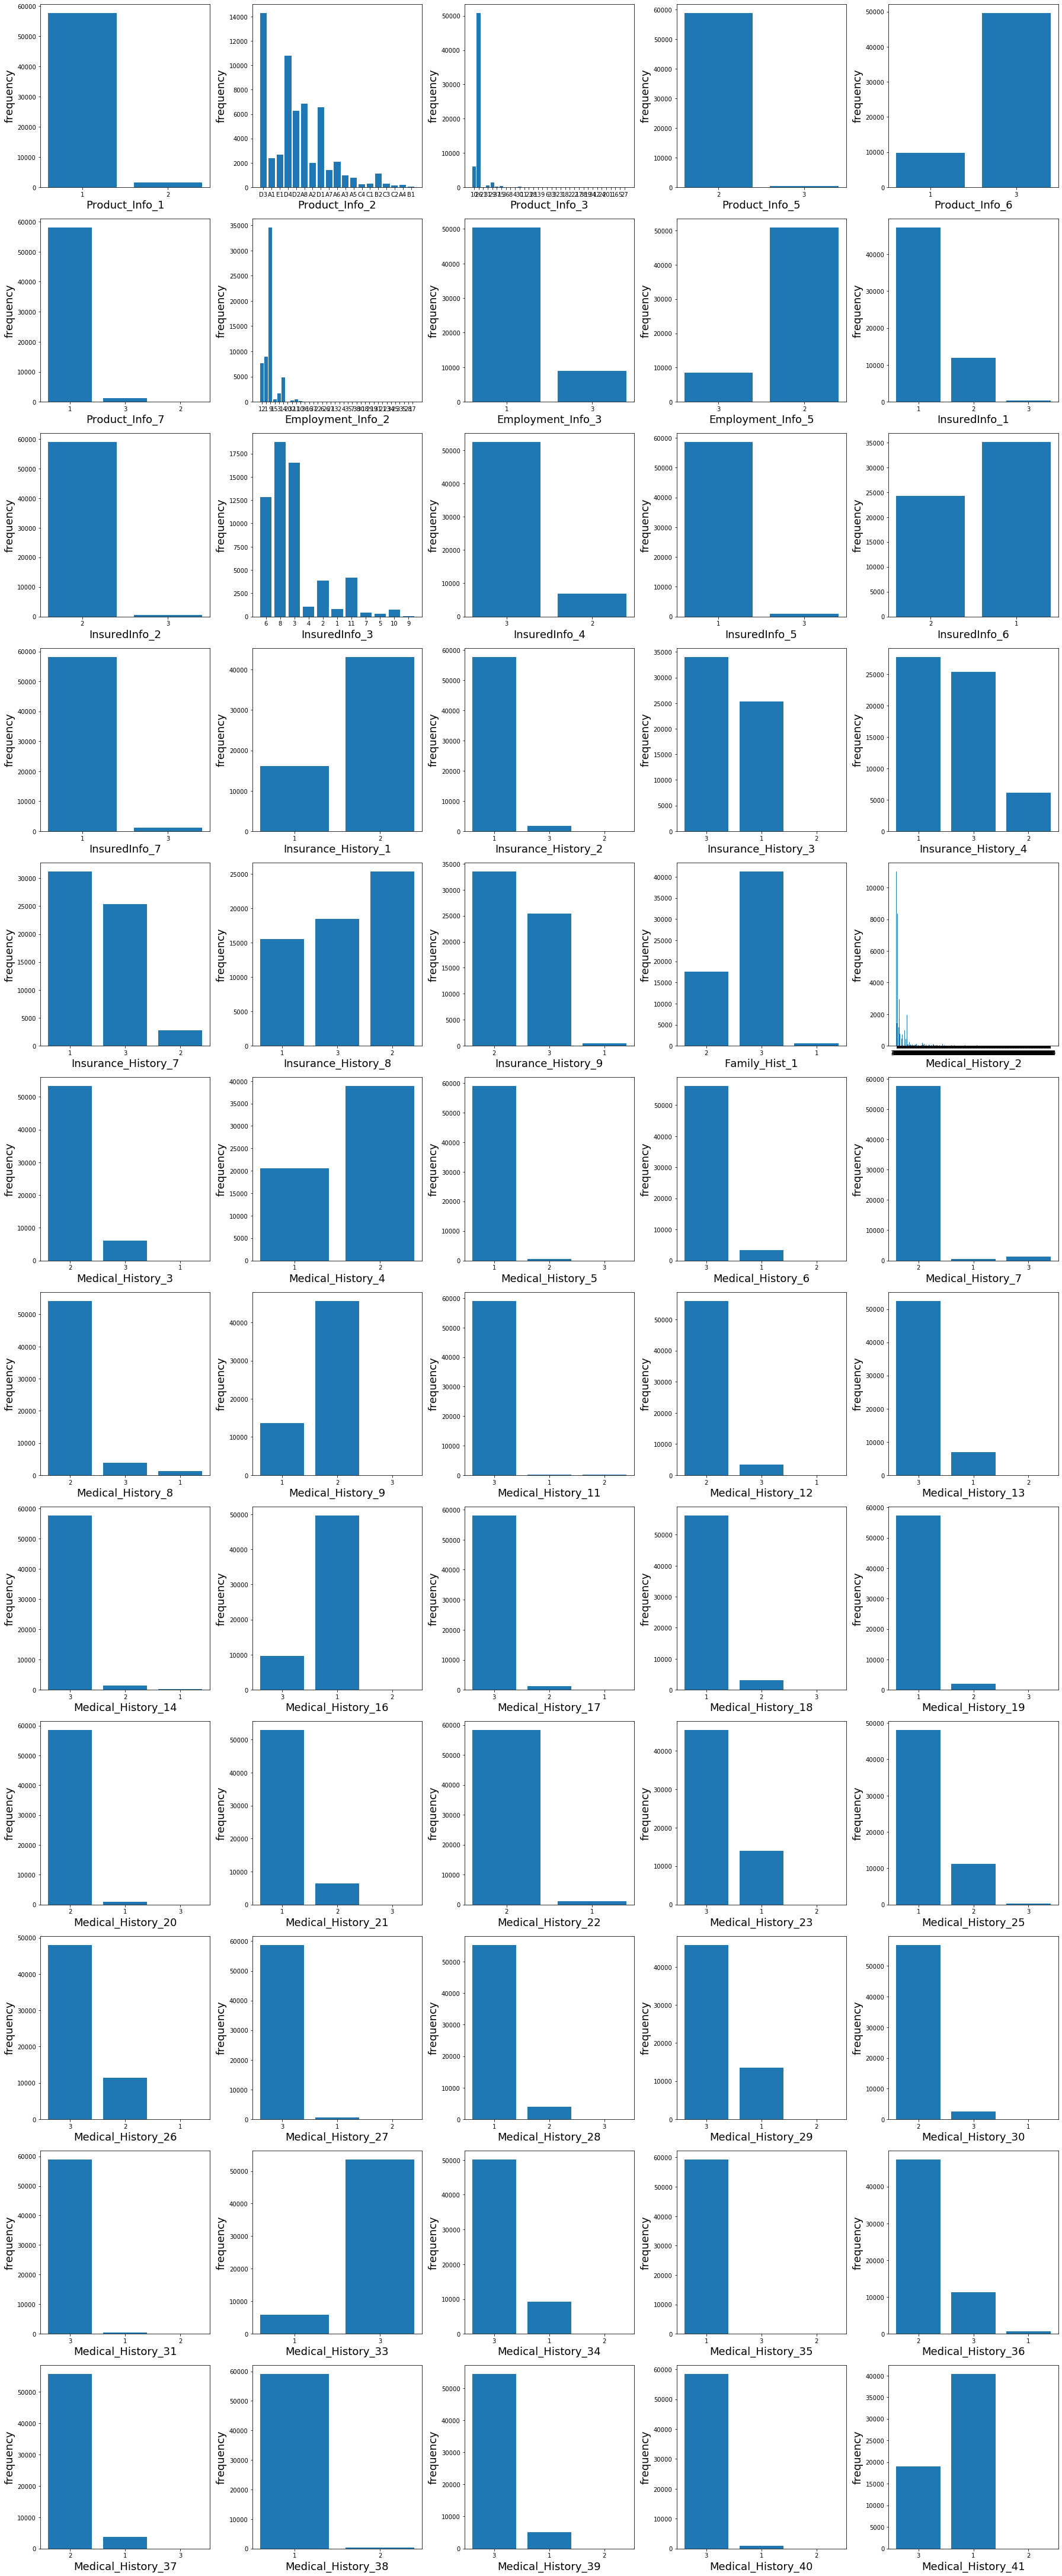

In [5]:
# take a look at the categorical columns without the id column
plot_categoricals(df_train[cat_cols[1:]])

Note that many values are appearing only in small numbers, so they might be not in the training set. When encoding, we must pass the whole dictionary before or use out-of-volume (oov) buckets.
Lets take a closer look at Product_Info_3, Employment_Info_2, Medical_History_2 and Medical_History_5.

Int64Index([  1,   2,   3,   5,   6,   7,   8,   9,  10,  12,
            ...
            639, 640, 641, 642, 643, 644, 645, 646, 647, 648],
           dtype='int64', length=579)


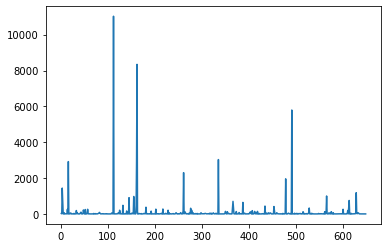

In [6]:
print(df_train['Medical_History_2'].value_counts().sort_index().index)
df_train['Medical_History_2'].value_counts().sort_index().plot()

So the values there range from 1 to 648, most number only appearing once. Therefore, we will not onehotencode this and treat it as an discrete column or use the sklearn KBinsDiscretizer and onehotencode. The same goes for Product_Info_3 and Employment_Info_2.

In [7]:
df_train['Medical_History_5'].value_counts()

1    58946
2      433
3        2
Name: Medical_History_5, dtype: int64

Again, the two 3's will probably not appear, but might be handles with bucket_oov. We will apply these to all other columns. Let's take a look at the id's:

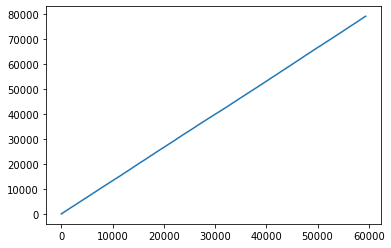

In [8]:
df_train['Id'].plot()

Okay, that's not the identity function, so there are jumps in the rows |--> id function. We will treat this one as a discrete function.

#### Continuous columns

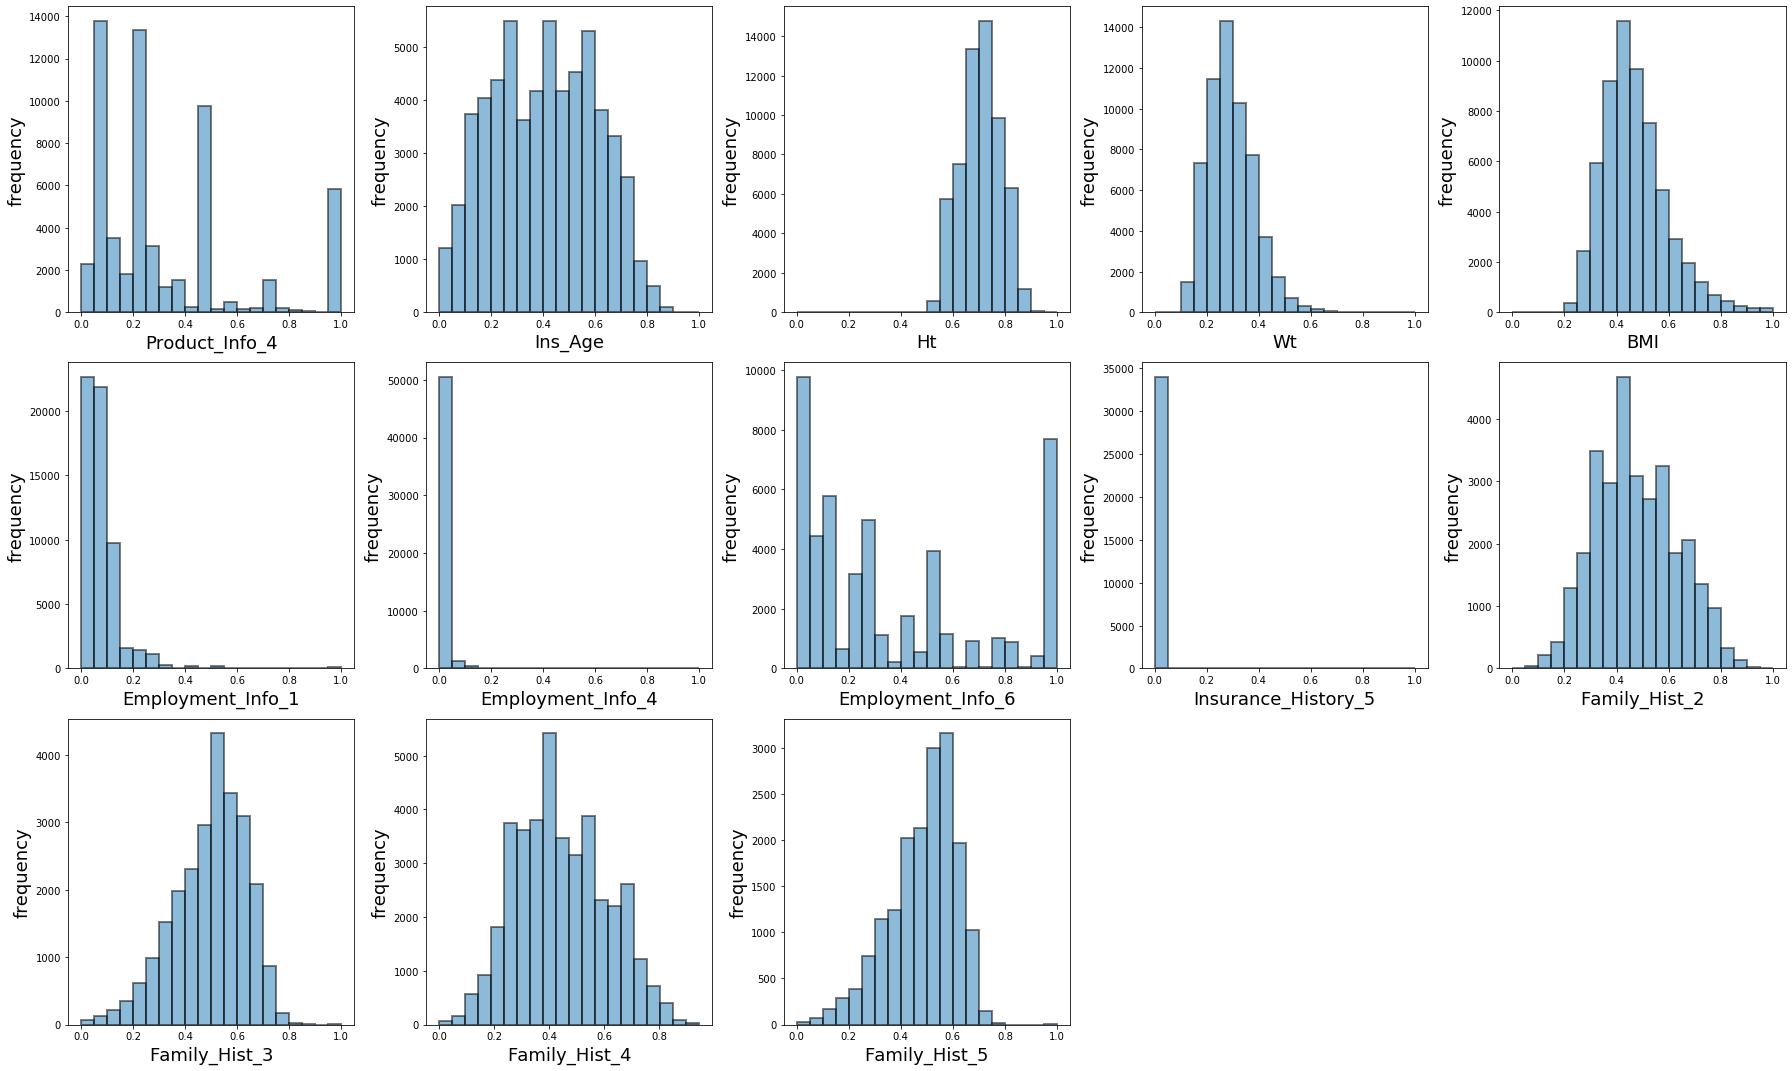

In [9]:
def plot_histograms(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        X = data[col].dropna()
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.hist(X, bins=20, alpha=0.5, \
                 edgecolor="black", linewidth=2.0)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_histograms(df_train[cont_cols])

We are going to make the data look more Gaussian distributed by using power transformation (yeo-johnson, similar to boxcox but works for arbitrary values). Let's see how it works:

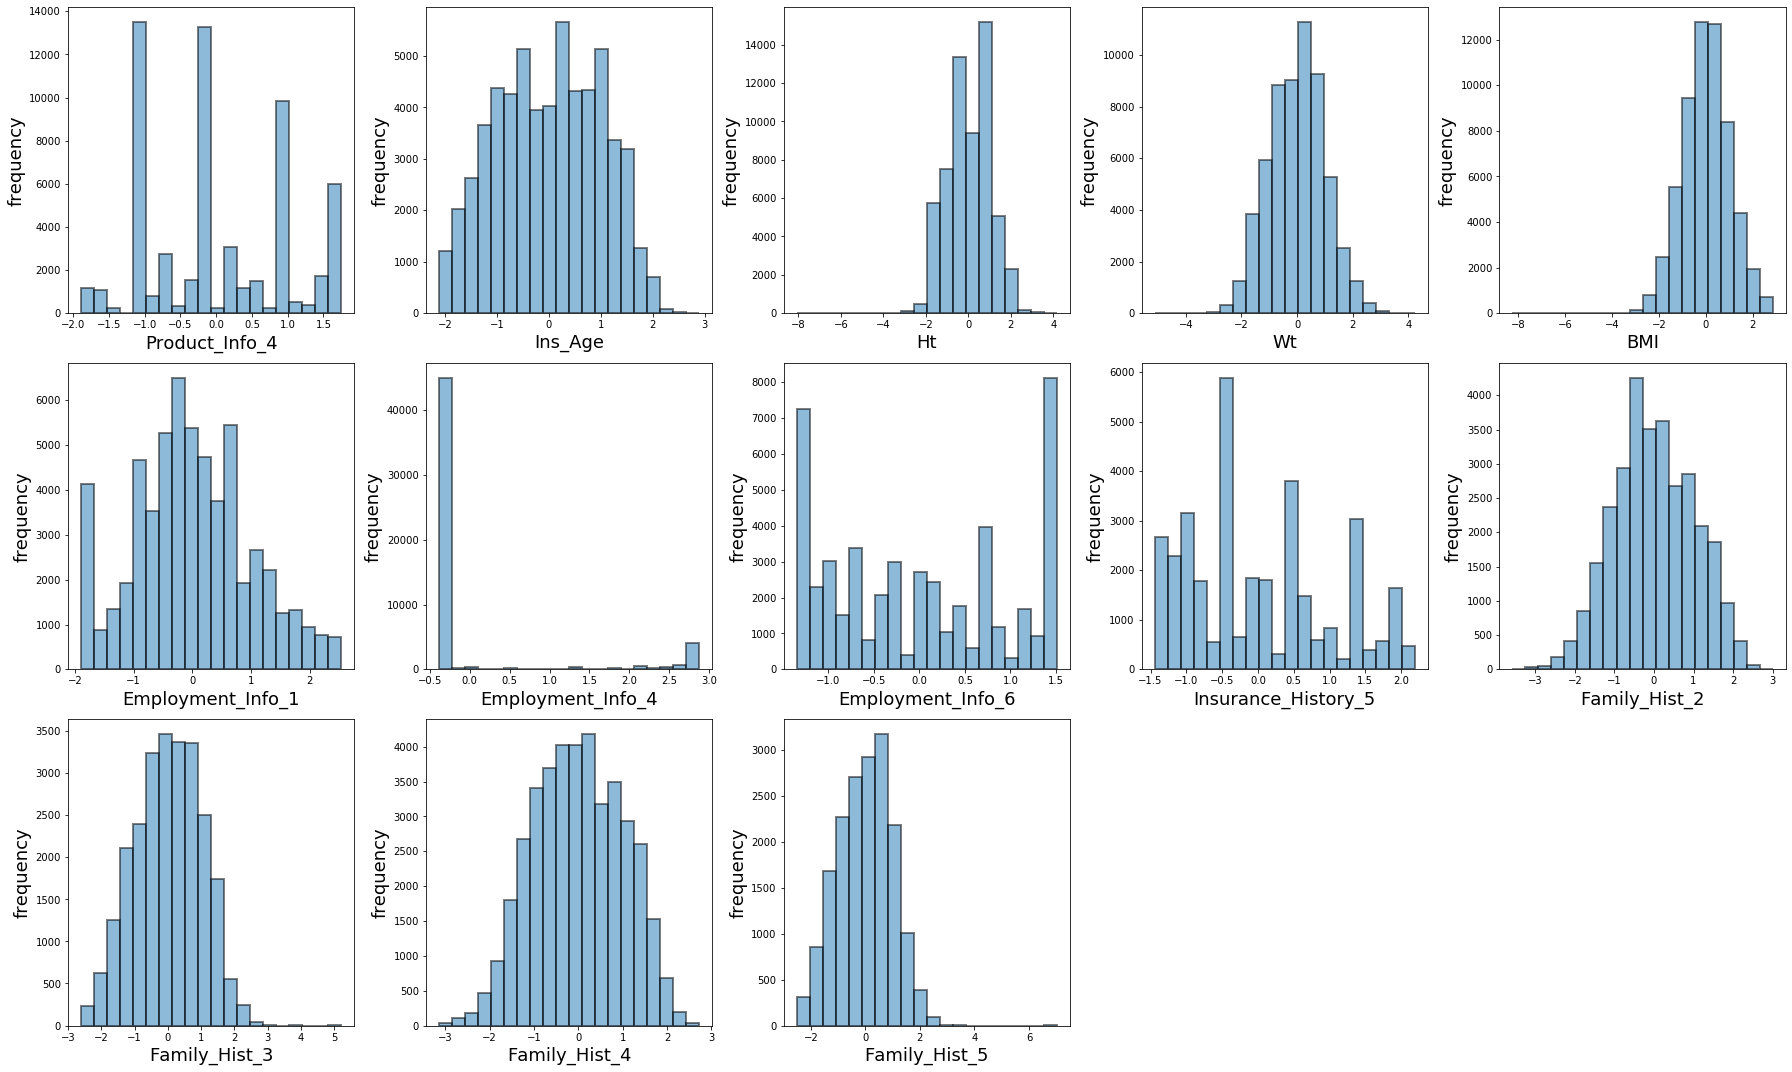

In [10]:
from sklearn.preprocessing import power_transform

cont_boxcox = df_train[cont_cols].copy()
for col in cont_cols:
    cont_boxcox[col] = power_transform(cont_boxcox[[col]], method='yeo-johnson')
plot_histograms(cont_boxcox)

It did not seem to change much in most columns, and for Product_Info_4, Employment_Info_4, Employment_Info_6 as well as Insurance_History_5, there is not much help in trying to make it Gaussian like. We will apply a KBinDiscretizer with 4, 2, 4 and 2 bins respectively (not applying power transformation):

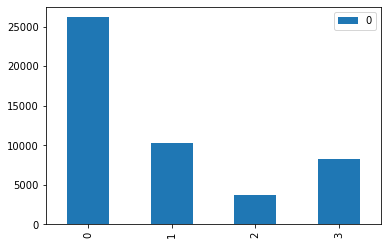

In [11]:
from sklearn.preprocessing import KBinsDiscretizer

kbd = KBinsDiscretizer(n_bins=4,encode='ordinal',strategy='kmeans')
# count number of occurences:
n_occur = np.bincount(kbd.fit_transform(df_train[['Employment_Info_6']].dropna()).astype(np.int8).reshape(-1))
pd.DataFrame(n_occur).plot(kind='bar')

It seems that we do not capture the four high bins as in the histogram of Product_Info_4 as well as in Employment_Info_6, but we will leave it like this.

In [12]:
df_train['Insurance_History_5'].value_counts()

0.000667    5336
0.001667    3553
0.003333    2885
0.000333    2496
0.001000    1530
            ... 
0.000192       1
0.000072       1
0.002293       1
0.000562       1
0.000771       1
Name: Insurance_History_5, Length: 2265, dtype: int64

[33982     3]


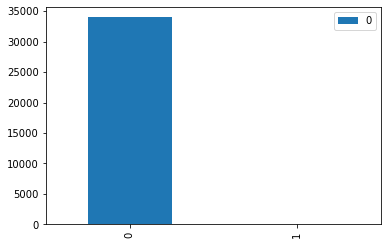

In [13]:
kbd = KBinsDiscretizer(n_bins=2,encode='ordinal',strategy='kmeans')
# count number of occurences:
n_occur = np.bincount(kbd.fit_transform(df_train[['Insurance_History_5']].dropna()).astype(np.int8).reshape(-1))
print(n_occur)
pd.DataFrame(n_occur).plot(kind='bar')

Well, thats way too bad to use. Of course, we could write an own class. Note that at least implementing the nones as -1 works well:

[25396 33985]


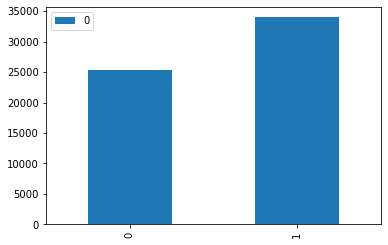

In [14]:
kbd = KBinsDiscretizer(n_bins=2,encode='ordinal',strategy='kmeans')
# count number of occurences:
n_occur = np.bincount(kbd.fit_transform(df_train[['Insurance_History_5']].fillna(value=-1)).astype(np.int8).reshape(-1))
print(n_occur)
pd.DataFrame(n_occur).plot(kind='bar')

#### Discrete columns
As we will see, those do not really look Gaussian. We will, together with nans, try to group the into three bins.

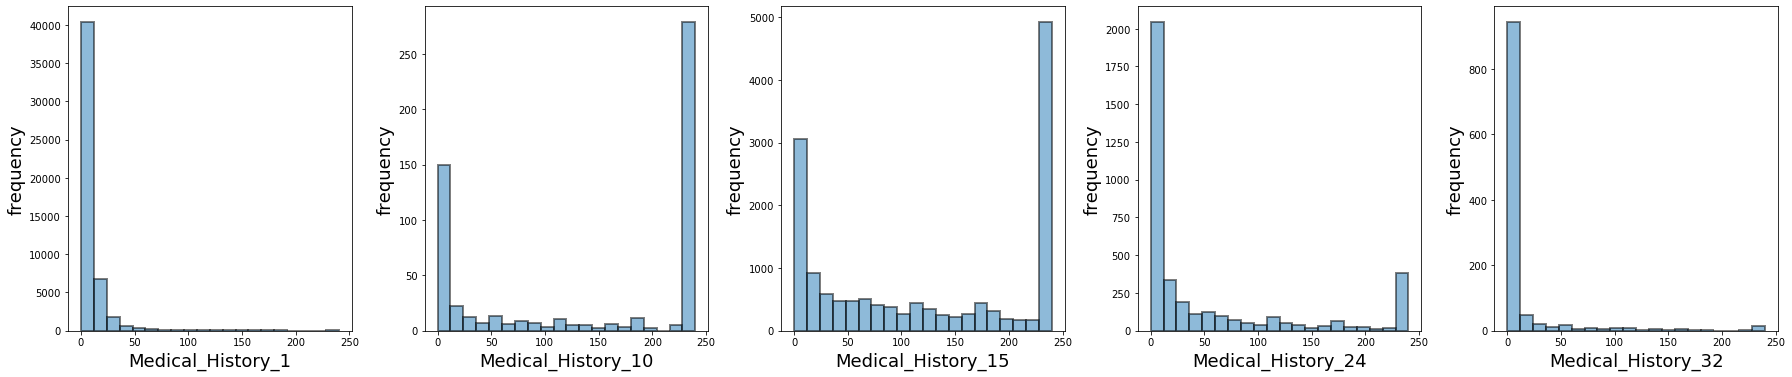

In [15]:
plot_histograms(df_train[disc_cols])

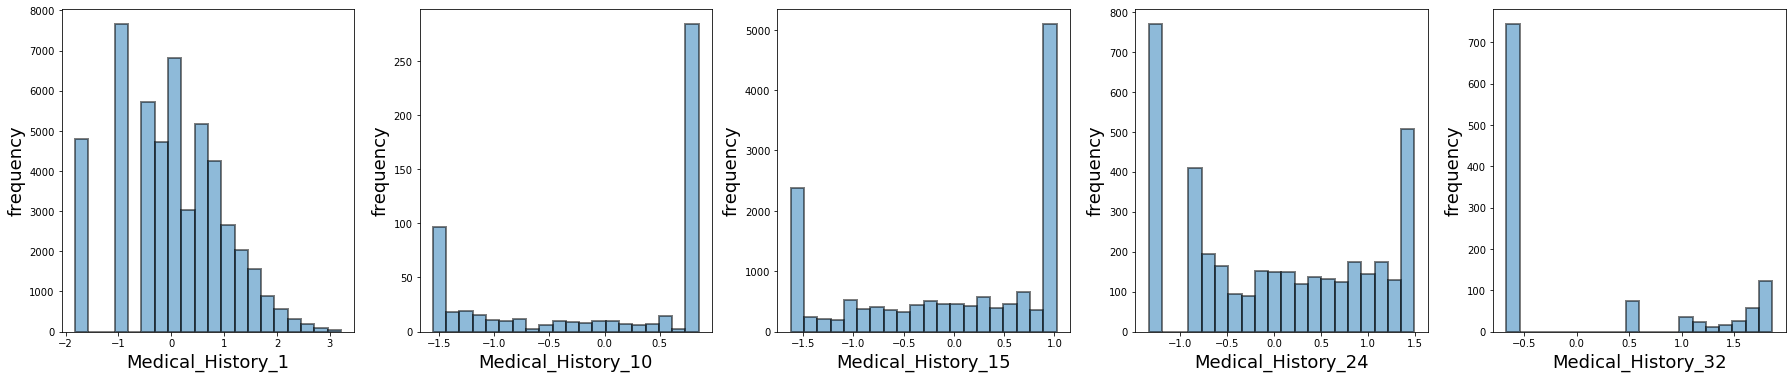

In [16]:
disc_ptrans = df_train[disc_cols].copy()

for col in disc_cols:
    disc_ptrans[col] = power_transform(disc_ptrans[[col]], method='yeo-johnson')

plot_histograms(disc_ptrans)

The non-transformed values range from 0 to 250. Lets set the nans to -250 and take three bins

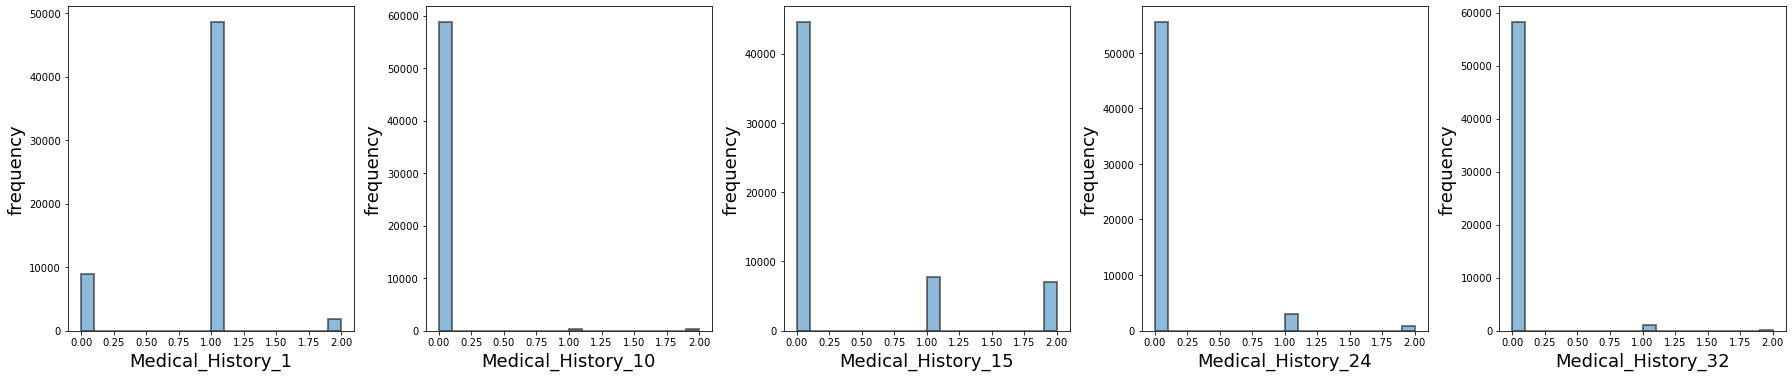

In [17]:
disc_kbins = df_train[disc_cols].copy()
kbd = KBinsDiscretizer(n_bins=3,encode='ordinal',strategy='kmeans')

for col in disc_cols:
    disc_kbins[col] = kbd.fit_transform(df_train[[col]].fillna(value=-250))

plot_histograms(disc_kbins)

Okay, lets leave it like this.

### Splitting the Data into Train and Test

In [18]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size=0.2, stratify=df_train['Response'].values, random_state=43)
train, val = train_test_split(train, test_size=0.2, stratify=train['Response'].values, random_state=43)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

38003 train examples
9501 validation examples
11877 test examples


### Data Preparation: Produce pipelines

So we are left with the following input to be preprocessed:

- We will use KBinsDiscretizer with 3 bins on the discrete data, i.e. Medical_History 1,10,15,24,32, filling missing data with -250
- For the continuous attributes, we will use the yeo-johnson transformation except for Product_Info_4, Employment_Info_4, Employment_Info_6 as well as Insurance_History_5: there, we will apply a KBinDiscretizer with 5, 2, 5 and 2 bins, where the nans are filled with -1
- Id, Medical_History_2, Product_Info_3 and Employment_Info_2 are considered as continuous data instead of categorical, being power transformed
- dummy and categorical should be onehotencoded.

This gives us essentially three types of input data: numerical, categorical to be onehotencoded and kbins.

In [19]:
# specify which attributes should be applied to KBinsDiscretizer with number of bins
kbins2_attribs = ['Employment_Info_4','Insurance_History_5']
kbins3_attribs = ['Medical_History_1','Medical_History_10','Medical_History_15', 'Medical_History_24',
                  'Medical_History_32']
kbins5_attribs = ['Product_Info_4', 'Employment_Info_6']

kbins = kbins2_attribs + kbins3_attribs + kbins5_attribs

# specifying which columns are numerical and which categorical
cat_attribs = [col for col in cat_cols + dummy_cols
               if col not in ['Id','Medical_History_2', 'Product_Info_3', 'Employment_Info_2']]

num_attribs = [x for x in df_train.columns if x not in cat_attribs and x not in ['Response']+kbins]
print("Length of num_attribs + cat_attribs + kbins is equal to", len(num_attribs+cat_attribs+kbins), "and should be 127")

Length of num_attribs + cat_attribs + kbins is equal to 127 and should be 127


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


num_pt_pipeline = Pipeline([('yeo_jo', PowerTransformer()), # applies yeo-johnson (similar to boxcox, but can be used for non-positive as well)
                             ('sim_imp', SimpleImputer(strategy='constant',fill_value=0))]# after standardization, medium is zero
                           )
num_npt_pipeline = Pipeline([('sim_imp', SimpleImputer(strategy='mean',fill_value=0))] # does not standardize, possibly id
                           )

# some pipelines for using KBinsDiscretizer, are not used as results are worse
kbins2_pipe = Pipeline([('sim_imp', SimpleImputer(strategy='constant',fill_value=-1)),
                        ('kbins', KBinsDiscretizer(n_bins=2, encode='onehot', strategy='kmeans'))]
                           )
kbins3_pipe = Pipeline([('sim_imp', SimpleImputer(strategy='constant',fill_value=-250)),
                        ('kbins', KBinsDiscretizer(n_bins=3, encode='onehot', strategy='kmeans'))]
                           )
kbins5_pipe = Pipeline([('sim_imp', SimpleImputer(strategy='constant',fill_value=-1)),
                        ('kbins', KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans'))]
                           )

# handle_unknown='ignore' sets everything to zero if unknown category is encountered
# there seems to be no easy way to implement oov_bucket except for writing own class
# alternatively, pass all possibilities when initializing
cat_pipeline = Pipeline([('one_hot', OneHotEncoder(handle_unknown='ignore'))])

full_pipeline = ColumnTransformer([
    ('num', num_pt_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ('kbins_2', kbins2_pipe, kbins2_attribs),
    ('kbins_3', kbins3_pipe, kbins3_attribs),
    ('kbins_5', kbins5_pipe, kbins5_attribs)
    ],
    remainder='drop') # remainder='drop' is default and drops all columns not in num_attribs or cat_attribs

### Keras first shot

At first, we just start with a simple sequential neural network. Note that its outcome expects classes from 0 to 7 instead of 1 to 8, so we have to relabel our targets.

In [21]:
# converting labels to numpy arrays, as keras will expect
# note that the pipeline will convert the dataframes to numpy arrays, the onehots being flattened
# so there is no need for to_numpy here

y_train = train.pop('Response').to_numpy() - 1 # so that target values range from 0 to 7, because keras.layers.Dense(8, activation='softmax') expecting range [0,8)
y_val = val.pop('Response').to_numpy() - 1
y_test = test.pop('Response').to_numpy() - 1

In [22]:
# train the pipeline and transform the data
train_piped = full_pipeline.fit_transform(train)
val_piped = full_pipeline.transform(val)
test_piped = full_pipeline.transform(test)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:184: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  centers = km.fit(column[:, None]).cluster_centers_[:, 0]
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


Ahh, we should have taken a closer look at Product_Info_4 and Employment_Info_6, as together with the nans, the clustering might not work as well anymore. Go on...

For the neural network, we use the best practice advice of Aurelien Geron in his book "Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow, p. 371 of the second edition. Playing a bit, they seem to be okay. We copy and paste the code for his implementation of Leslie Smiths 1cycle scheduler.

In [23]:
# define the 1cycle by Leslie Smith
import tensorflow as tf
import keras
import keras.backend as K

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [24]:
# we define a function that returns a sequential model with variable repition of dropout layer,
# batch normalization and dense layer, finally followed by the output layer
def get_seq_model(output_neurons=None, output_activation=None, n_hidden=3, n_neurons = 200,input_shape=None,
                       batch_normal=True,dropout_rate=0,activation='elu',kernel_initializer='he_normal'):
    model = keras.models.Sequential()
    
    if input_shape is not None:
        model.add(keras.layers.Flatten(input_shape=input_shape))
    
    for i in range(n_hidden): # add the hidden layers in order (some layers if set to true) dropout, normalization, dense
        # only add drop layers in the last three layers
        if dropout_rate != 0 and i > n_hidden-4:
            model.add(keras.layers.Dropout(rate=dropout_rate))
        if batch_normal:
            model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer))
    
    # set the last layers
    if dropout_rate != 0:
            model.add(keras.layers.Dropout(rate=dropout_rate))
    if batch_normal:
            model.add(keras.layers.BatchNormalization())
    if output_neurons is not None and output_activation is not None:
        model.add(keras.layers.Dense(output_neurons, activation=output_activation, kernel_initializer=kernel_initializer))
    
    return model
    
def get_seq_comp_model(output_neurons, output_activation,loss,
                       metrics,optimizer='nadam',n_hidden=2,n_neurons = 100,
                       input_shape=None, batch_normal=True,dropout_rate=0,activation='elu',
                       kernel_initializer='he_normal'):
    
    model = get_seq_model(output_neurons=output_neurons, output_activation=output_activation, n_hidden=n_hidden,
                          n_neurons = n_neurons,input_shape=input_shape, batch_normal=batch_normal,
                          dropout_rate=dropout_rate, activation=activation,kernel_initializer=kernel_initializer)
    
    model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
    
    return model


model = get_seq_comp_model(8,'softmax',loss='sparse_categorical_crossentropy',activation='elu',
                           kernel_initializer='he_normal',metrics=['accuracy'],n_hidden=3,n_neurons=200)

In [25]:
def fit_model(model, X_train,y_train,X_val,y_val,batch_size=32,n_epochs=20,early_stopping_patience=5,
              onecycle_max_rate=0.05):
    """fits a model and returns history"""
    onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=onecycle_max_rate)
    if early_stopping_patience == 0:
        callbacks=[onecycle]
    else:
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=early_stopping_patience,
                                                          restore_best_weights=True)
        callbacks=[onecycle,early_stopping_cb]
        
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    callbacks=callbacks, validation_data=(X_val,y_val))
    return history
    
# note that we must apply the transformed data
history = fit_model(model,train_piped, y_train,
                    val_piped,y_val,n_epochs=30,early_stopping_patience=10,
                   onecycle_max_rate=0.05,batch_size=32)

Train on 38003 samples, validate on 9501 samples
Epoch 1/30
38003/38003 [==============================] - 8s 220us/step - loss: 1.4453 - accuracy: 0.4772 - val_loss: 1.3640 - val_accuracy: 0.5203
Epoch 2/30
38003/38003 [==============================] - 7s 195us/step - loss: 1.3301 - accuracy: 0.5077 - val_loss: 1.3461 - val_accuracy: 0.5104
Epoch 3/30
38003/38003 [==============================] - 7s 195us/step - loss: 1.3198 - accuracy: 0.5163 - val_loss: 1.3459 - val_accuracy: 0.5246
Epoch 4/30
38003/38003 [==============================] - 7s 194us/step - loss: 1.3110 - accuracy: 0.5195 - val_loss: 1.3750 - val_accuracy: 0.4959
Epoch 5/30
38003/38003 [==============================] - 7s 191us/step - loss: 1.3078 - accuracy: 0.5180 - val_loss: 1.3855 - val_accuracy: 0.5245
Epoch 6/30
38003/38003 [==============================] - 7s 187us/step - loss: 1.3092 - accuracy: 0.5193 - val_loss: 1.5138 - val_accuracy: 0.4974
Epoch 7/30
38003/38003 [==============================] - 7s 18

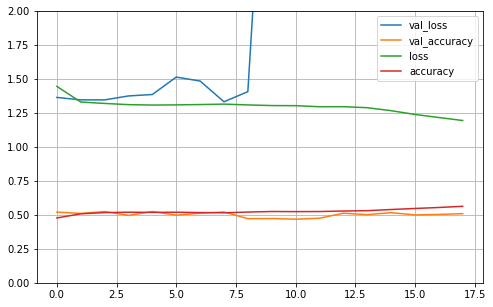

In [26]:
def show_history(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # sets vertical range to interval [0,1]
    plt.show()
    
show_history(model.history)

In [27]:
from sklearn.metrics import cohen_kappa_score
y_pred = model.predict_classes(val_piped)
score = cohen_kappa_score(y_val,y_pred,weights='quadratic')
score

0.5394948955434795

When running this notebook, I noticed that the performance of the model really changes from run to run, so I wanted to do a gridsearch looking for an initialization that gives a more stable training result by wrapping up the keras model to a scikit-learn one, but there seems to be a bug with it:

"RuntimeError: Cannot clone object <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f6525580b90>, as the constructor either does not set or modifies parameter metrics"

See:
https://github.com/keras-team/keras/issues/13586

For completeness, I included the code:

In [28]:
if False:
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import cohen_kappa_score, make_scorer

    # define the cohen kappa scorer for the gridsearch
    cohen_kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

    # wraps neural network to sklearn and set params
    model_sklearn = keras.wrappers.scikit_learn.KerasClassifier(get_seq_comp_model)
    params = {
        'output_neurons': [8],
        'output_activation': ['softmax'],
        'loss': ['sparse_categorical_crossentropy'],
        'metrics': [['accuracy']],
        'n_hidden': [3],#,5],
        'n_neurons': [200],#,500,1000],
        #'activation': ['selu','elu'],
        'kernel_initializer': ['lecun_normal', 'he_normal']    
    }
    # initialize onecycle (train size 38000, 20 epochs, batch size 32) and early stopping (patience=5)
    onecycle = OneCycleScheduler(38000 // 32 * 20, max_rate=0.05)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
    callbacks=[onecycle,early_stopping_cb]

    gs = GridSearchCV(model_sklearn, params, cv=3, scoring=cohen_kappa_scorer)
    gs.fit(train_piped, y_train, validation_data=(val_piped,y_val), epochs=20, callbacks=callbacks)

So I manually twisted a little bit the hyperparameters and increasing the batch size helped a bit, presumably because the data is sensitive to outliers which appear seldom but have a lot of effect (like having medical history). I ended up with using onecycle_max_rate 0.005,activation selu and batch size 128, but the results still vary and there are probably better configurations:

Train on 38003 samples, validate on 9501 samples
Epoch 1/30
38003/38003 [==============================] - 5s 128us/step - loss: 1.5626 - accuracy: 0.4510 - val_loss: 1.4224 - val_accuracy: 0.4914
Epoch 2/30
38003/38003 [==============================] - 4s 96us/step - loss: 1.3466 - accuracy: 0.5034 - val_loss: 1.3750 - val_accuracy: 0.4961
Epoch 3/30
38003/38003 [==============================] - 4s 101us/step - loss: 1.2806 - accuracy: 0.5300 - val_loss: 1.3513 - val_accuracy: 0.5079
Epoch 4/30
38003/38003 [==============================] - 4s 97us/step - loss: 1.2475 - accuracy: 0.5417 - val_loss: 1.3512 - val_accuracy: 0.5114
Epoch 5/30
38003/38003 [==============================] - 4s 94us/step - loss: 1.2251 - accuracy: 0.5492 - val_loss: 1.3393 - val_accuracy: 0.5182
Epoch 6/30
38003/38003 [==============================] - 4s 98us/step - loss: 1.2042 - accuracy: 0.5598 - val_loss: 1.3518 - val_accuracy: 0.5146
Epoch 7/30
38003/38003 [==============================] - 4s 95us/s

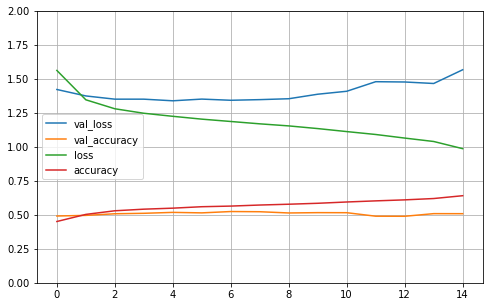

0.5320541195117701


In [29]:
model = get_seq_comp_model(8,'softmax',loss='sparse_categorical_crossentropy',activation='selu',
                           kernel_initializer='he_normal',metrics=['accuracy'],n_hidden=3,n_neurons=200)
history = fit_model(model,train_piped, y_train,
                    val_piped,y_val,n_epochs=30,early_stopping_patience=10,
                   onecycle_max_rate=0.005,batch_size=128)
show_history(model.history)
y_pred = model.predict_classes(val_piped)
score = cohen_kappa_score(y_val,y_pred,weights='quadratic')
print(score)

Check the performance when we just drop out the columns with missing names, doing no preprocessing (but then use batch normalization layers!):

In [30]:
train_vanilla = train.drop(list(df_missing.index)+['Product_Info_2'], axis='columns').to_numpy()
val_vanilla = val.drop(list(df_missing.index)+['Product_Info_2'], axis='columns').to_numpy()


model_vanilla = get_seq_comp_model(8,'softmax',loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'],activation='selu', n_hidden=3,n_neurons = 200)
history_vanilla = fit_model(model_vanilla,train_vanilla, y_train,
                    val_vanilla,y_val,
                   onecycle_max_rate=0.005,batch_size=128)

Train on 38003 samples, validate on 9501 samples
Epoch 1/20
38003/38003 [==============================] - 5s 119us/step - loss: 1.6116 - accuracy: 0.4358 - val_loss: 1.5010 - val_accuracy: 0.4535
Epoch 2/20
38003/38003 [==============================] - 3s 90us/step - loss: 1.4077 - accuracy: 0.4821 - val_loss: 1.4052 - val_accuracy: 0.4898
Epoch 3/20
38003/38003 [==============================] - 3s 90us/step - loss: 1.3579 - accuracy: 0.4993 - val_loss: 1.4059 - val_accuracy: 0.4943
Epoch 4/20
38003/38003 [==============================] - 3s 89us/step - loss: 1.3340 - accuracy: 0.5080 - val_loss: 1.3971 - val_accuracy: 0.4923
Epoch 5/20
38003/38003 [==============================] - 3s 88us/step - loss: 1.3177 - accuracy: 0.5176 - val_loss: 1.3795 - val_accuracy: 0.5039
Epoch 6/20
38003/38003 [==============================] - 3s 85us/step - loss: 1.3058 - accuracy: 0.5176 - val_loss: 1.3995 - val_accuracy: 0.4944
Epoch 7/20
38003/38003 [==============================] - 3s 87us/st

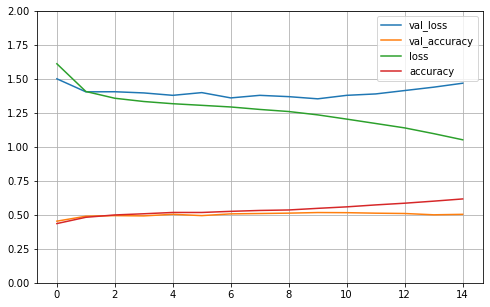

In [31]:
show_history(model_vanilla.history)

In [32]:
y_pred = model_vanilla.predict_classes(val_vanilla)
score = cohen_kappa_score(y_val,y_pred,weights='quadratic')
score

0.5108436028971003

Okay, at least Feature Engineering seemed to do any good. But given that the top scorers on kaggle achieve 0.68 to 0.69, we are quite bad. At least, we did not overfit the data. Let's take a quick glance on how some quick vanilla scikit-learn estimators perform:

In [33]:
if True: # for working on this notebook, we set it to False to avoid time using for useless training
    from sklearn.linear_model import LogisticRegression, SGDClassifier
    from sklearn.svm import LinearSVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier

    from sklearn.pipeline import make_pipeline

    log_reg = make_pipeline(StandardScaler(),LogisticRegression(random_state=43))
    sgd = make_pipeline(StandardScaler(),SGDClassifier(random_state=43))
    rnd_for = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=43, n_jobs = -1))
    neu_net = make_pipeline(StandardScaler(),MLPClassifier(random_state=43))

    clf_list = [('log_reg',log_reg),('sgd',sgd),('rnd_for',rnd_for),('neu_net',neu_net)]

In [34]:
if True: # for working on this notebook, we set it to False to avoid time using for useless training
    for clf_name, clf in clf_list:
        clf.fit(full_pipeline.transform(train), y_train)
        print("Score of", clf_name, "on validation:", cohen_kappa_score(y_val, clf.predict(full_pipeline.transform(val)),weights='quadratic'))
        print("Score of", clf_name, "on test:", cohen_kappa_score(y_test, clf.predict(full_pipeline.transform(test)),weights='quadratic'))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score of log_reg on validation: 0.5180624084629106
Score of log_reg on test: 0.5139421228391101
Score of sgd on validation: 0.45070553164339655
Score of sgd on test: 0.45803006672256696
Score of rnd_for on validation: 0.4984501264429999
Score of rnd_for on test: 0.5057241718851399


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Score of neu_net on validation: 0.47001846068666575
Score of neu_net on test: 0.4714163698514484


If not much, we are at least a little bit better, but we did not any fine-tuning with the scikit-guys (and we could do more fine tuning on our model, but it is not worth its efforts as we are far away from being competitive).

Next idea would be to implement multiple output in our model. By now, the metric is accuracy and it is unimportant if I miss a 5 by 6 or 8. On the other hand, the Cohen-Kappa punishes a difference of 3 much more heavily than a difference of 1. To train the network giving up accuracy a little bit for hitting near the right one, we would implement another output which predicts if the label has distance smaller than 1.

### The confusion matrix of our model

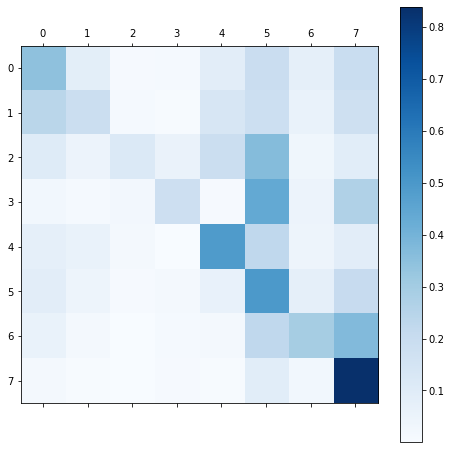

In [35]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_val,y_pred)

def plot_confusion_matrix(matrix, error_rates=True, fill_diag_zero=False, cmap='Blues'):
    """plots the confusion matrix, where error_rates gives the normalized error (each valued divided by the 
    by the total number of such classes), fill_diag_zero fills the diagonal with zeros so you can 
    concentrate on the error"""
    
    if error_rates:
        row_sums = matrix.sum(axis=1, keepdims=True)
        matrix = matrix / row_sums
    
    if fill_diag_zero:
        np.fill_diagonal(matrix, 0)
        
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix,cmap=cmap)
    fig.colorbar(cax)

plot_confusion_matrix(conf_mx)

Throughout, all but class 7 are confused with class 5, but in general with classes 5-7 (with different runs, sometimes 4-7). We will therefore try to predict if a class belongs to 0-4 or to 5-7 and afterwards train our model to first distinct this and then classify the particular classes 0 to 7.

### Prebuild: Try predict classes 0-4 or 5-7
Here, we are just trying to predict when an instance belongs to class 0,1,2,3,4 or not and see how good we will be with a sequential model and how many hidden layers we will need. If fruitful, we will add two additional layers and then predict the actual class. Then, we will experiment how to weight the outputs to get a good result.

In [36]:
# create new labels
def binarizer(x):
    if x in [0,1,2,3,4]:
        return 0
    elif x in [5,6,7]:
        return 1
    else:
        print("Error: Could not convert element of given array")

z_train = np.array([binarizer(x) for x in y_train])
z_val = np.array([binarizer(x) for x in y_val])
z_test = np.array([binarizer(x) for x in y_test])

print(z_train[:35])
print(y_train[:35])

[1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0]
[5 4 4 1 7 1 5 7 6 7 1 7 4 7 7 1 7 6 5 6 5 0 7 5 6 5 6 7 7 7 7 2 7 0 4]


In [37]:
model_bin = get_seq_comp_model(1,'sigmoid',loss='binary_crossentropy', activation='selu',
                           metrics=[tf.keras.metrics.Precision()],n_hidden=2,n_neurons = 200)

In [38]:
history_bin = fit_model(model_bin,full_pipeline.transform(train),z_train,
                    full_pipeline.transform(val),z_val,n_epochs=30,early_stopping_patience=10,
                   onecycle_max_rate=0.005, batch_size=128)
"""ValueError: You are passing a target array of shape (38003, 1) while using as loss `categorical_crossentropy`.
`categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes).
If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead,
which does expect integer targets.
"""

Train on 38003 samples, validate on 9501 samples
Epoch 1/30
38003/38003 [==============================] - 4s 96us/step - loss: 0.5175 - precision: 0.7865 - val_loss: 0.4943 - val_precision: 0.7900
Epoch 2/30
38003/38003 [==============================] - 3s 74us/step - loss: 0.4679 - precision: 0.7924 - val_loss: 0.4769 - val_precision: 0.7954
Epoch 3/30
38003/38003 [==============================] - 3s 75us/step - loss: 0.4431 - precision: 0.7984 - val_loss: 0.4677 - val_precision: 0.8006
Epoch 4/30
38003/38003 [==============================] - 3s 74us/step - loss: 0.4298 - precision: 0.8029 - val_loss: 0.4798 - val_precision: 0.8051
Epoch 5/30
38003/38003 [==============================] - 3s 75us/step - loss: 0.4220 - precision: 0.8069 - val_loss: 0.4848 - val_precision: 0.8084
Epoch 6/30
38003/38003 [==============================] - 3s 74us/step - loss: 0.4155 - precision: 0.8100 - val_loss: 0.4728 - val_precision: 0.8112
Epoch 7/30
38003/38003 [==============================] -

'ValueError: You are passing a target array of shape (38003, 1) while using as loss `categorical_crossentropy`.\n`categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes).\nIf your targets are integer classes, you can convert them to the expected format via:\n```\nfrom keras.utils import to_categorical\ny_binary = to_categorical(y_int)\n```\n\nAlternatively, you can use the loss function `sparse_categorical_crossentropy` instead,\nwhich does expect integer targets.\n'

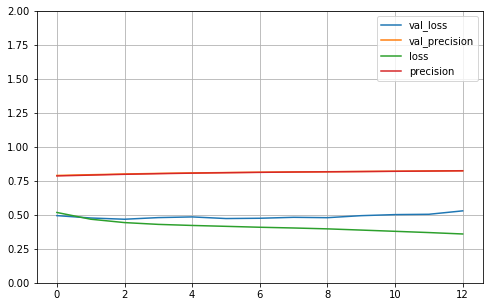

In [39]:
show_history(history_bin)

In [40]:
z_pred = model_bin.predict_classes(full_pipeline.transform(val))

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(z_val,z_pred))
print("Recall:", recall_score(z_val,z_pred))
print("F1 score:", f1_score(z_val,z_pred))

Precision: 0.7937142857142857
Recall: 0.8962735925149218
F1 score: 0.8418819607546026


Okay, lets leave it like this. Let's try to put both models together:

### Building a model with second output 1 vs. all

In [42]:
def comp_model_aux_out(losses,metrics,optimizer='nadam', activation='selu',
                       n_hidden_total=5, loss_weights=[0.8,0.2],
                       n_hidden_aux=3,
                       n_neurons = 100
                      ):
    
    input_layer = keras.layers.Input(shape=[312,]) # full_pipeline.transform(train) has shape (instances, 312)
    seq_layers_first = get_seq_model(n_neurons=n_neurons,n_hidden=n_hidden_aux,activation='selu')(input_layer)
    seq_layers_second = get_seq_model(n_neurons=n_neurons,n_hidden=n_hidden_total-n_hidden_aux,
                                     activation='selu')(seq_layers_first)
    batch_norm_aux = keras.layers.BatchNormalization()(seq_layers_first)
    batch_norm_main = keras.layers.BatchNormalization()(seq_layers_second)
    output_aux = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal',
                                    name='aux_output')(batch_norm_aux)
    output_main = keras.layers.Dense(8, activation='softmax', kernel_initializer='he_normal',
                                    name='main_output')(batch_norm_main)

    
    model = keras.models.Model(inputs=[input_layer],
                           outputs=[output_main, output_aux])
    
    model.compile(optimizer=optimizer,loss=losses,loss_weights=loss_weights,metrics=metrics)
    
    return model


model_two_outs = comp_model_aux_out(['sparse_categorical_crossentropy','binary_crossentropy'],
                            ['accuracy', 'accuracy'], n_neurons = 200)

In [43]:
history_two_outs = fit_model(model_two_outs,full_pipeline.transform(train), [y_train,z_train],
                    full_pipeline.transform(val),[y_val,z_val],n_epochs=30,early_stopping_patience=10,
                   onecycle_max_rate=0.005,batch_size=128)

Train on 38003 samples, validate on 9501 samples
Epoch 1/30
38003/38003 [==============================] - 9s 237us/step - loss: 1.3468 - main_output_loss: 1.5522 - aux_output_loss: 0.5249 - main_output_accuracy: 0.4509 - aux_output_accuracy: 0.7452 - val_loss: 1.2214 - val_main_output_loss: 1.4070 - val_aux_output_loss: 0.4850 - val_main_output_accuracy: 0.4952 - val_aux_output_accuracy: 0.7750
Epoch 2/30
38003/38003 [==============================] - 6s 154us/step - loss: 1.1507 - main_output_loss: 1.3216 - aux_output_loss: 0.4665 - main_output_accuracy: 0.5138 - aux_output_accuracy: 0.7825 - val_loss: 1.1806 - val_main_output_loss: 1.3604 - val_aux_output_loss: 0.4693 - val_main_output_accuracy: 0.5038 - val_aux_output_accuracy: 0.7803
Epoch 3/30
38003/38003 [==============================] - 6s 157us/step - loss: 1.1087 - main_output_loss: 1.2735 - aux_output_loss: 0.4494 - main_output_accuracy: 0.5304 - aux_output_accuracy: 0.7940 - val_loss: 1.1909 - val_main_output_loss: 1.3728 

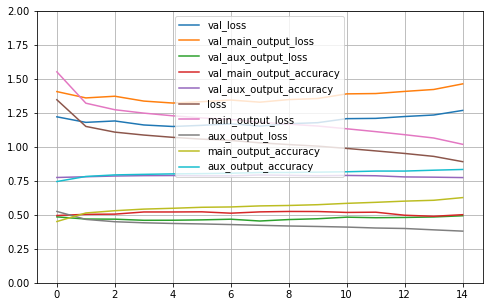

In [44]:
show_history(history_two_outs)

In [45]:
y_pred = model_two_outs.predict(full_pipeline.transform(val))[0].argmax(axis=-1)
score = cohen_kappa_score(y_val,y_pred,weights='quadratic')
score

0.5412606483419155

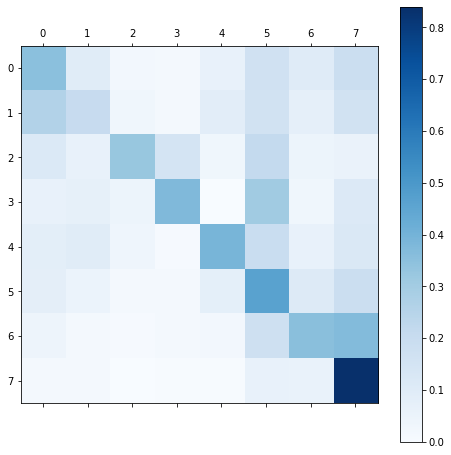

In [46]:
conf_mx2 = confusion_matrix(y_val,y_pred)

plot_confusion_matrix(conf_mx2)

That is roughly the same, and balancing more the loss weight to the auxiliary output gives worse results. In fact, we were cheating because we now had 5 hidden layers. So let's test the old model with 5 hidden layers to compare:

Train on 38003 samples, validate on 9501 samples
Epoch 1/30
38003/38003 [==============================] - 7s 184us/step - loss: 1.5517 - accuracy: 0.4497 - val_loss: 1.4299 - val_accuracy: 0.4993
Epoch 2/30
38003/38003 [==============================] - 5s 144us/step - loss: 1.3206 - accuracy: 0.5149 - val_loss: 1.3883 - val_accuracy: 0.4985
Epoch 3/30
38003/38003 [==============================] - 6s 146us/step - loss: 1.2716 - accuracy: 0.5304 - val_loss: 1.3457 - val_accuracy: 0.5151
Epoch 4/30
38003/38003 [==============================] - 6s 148us/step - loss: 1.2510 - accuracy: 0.5390 - val_loss: 1.3777 - val_accuracy: 0.5115
Epoch 5/30
38003/38003 [==============================] - 5s 142us/step - loss: 1.2328 - accuracy: 0.5449 - val_loss: 1.3395 - val_accuracy: 0.5182
Epoch 6/30
38003/38003 [==============================] - 5s 142us/step - loss: 1.2151 - accuracy: 0.5520 - val_loss: 1.3544 - val_accuracy: 0.5048
Epoch 7/30
38003/38003 [==============================] - 5s 13

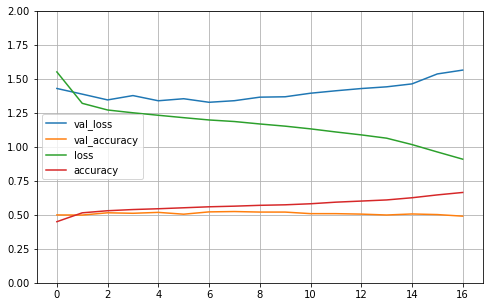

0.5177619066803538


In [47]:
model_5_hidden = get_seq_comp_model(8,'softmax',loss='sparse_categorical_crossentropy',activation='selu',
                           kernel_initializer='he_normal',metrics=['accuracy'],n_hidden=5,n_neurons=200)
history_5_hidden = fit_model(model_5_hidden,train_piped, y_train,
                    val_piped,y_val,n_epochs=30,early_stopping_patience=10,
                   onecycle_max_rate=0.005,batch_size=128)
show_history(model_5_hidden.history)
y_pred = model_5_hidden.predict_classes(val_piped)
score = cohen_kappa_score(y_val,y_pred,weights='quadratic')
print(score)

Let's increase additionally the number of neurons as a last point (we have 312 features after transformation, so let us set the number of neurons to 320, more than we need)

Train on 38003 samples, validate on 9501 samples
Epoch 1/30
38003/38003 [==============================] - 9s 246us/step - loss: 1.5353 - accuracy: 0.4581 - val_loss: 1.4555 - val_accuracy: 0.5019
Epoch 2/30
38003/38003 [==============================] - 7s 188us/step - loss: 1.3159 - accuracy: 0.5170 - val_loss: 1.3899 - val_accuracy: 0.4996
Epoch 3/30
38003/38003 [==============================] - 7s 192us/step - loss: 1.2696 - accuracy: 0.5294 - val_loss: 1.3374 - val_accuracy: 0.5144
Epoch 4/30
38003/38003 [==============================] - 7s 188us/step - loss: 1.2463 - accuracy: 0.5420 - val_loss: 1.3393 - val_accuracy: 0.5157
Epoch 5/30
38003/38003 [==============================] - 8s 198us/step - loss: 1.2286 - accuracy: 0.5488 - val_loss: 1.3420 - val_accuracy: 0.5148
Epoch 6/30
38003/38003 [==============================] - 7s 192us/step - loss: 1.2121 - accuracy: 0.5534 - val_loss: 1.3534 - val_accuracy: 0.5104
Epoch 7/30
38003/38003 [==============================] - 7s 18

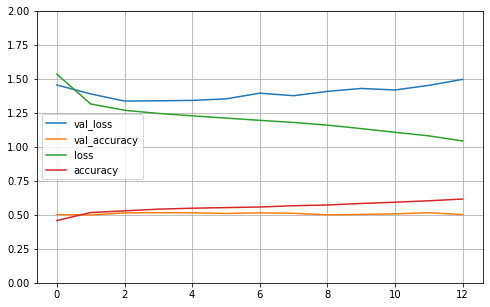

0.5333511425621964


In [48]:
model_full = get_seq_comp_model(8,'softmax',loss='sparse_categorical_crossentropy',activation='selu',
                           kernel_initializer='he_normal',metrics=['accuracy'],n_hidden=5,n_neurons=320)
history_full = fit_model(model_full,train_piped, y_train,
                    val_piped,y_val,n_epochs=30,early_stopping_patience=10,
                   onecycle_max_rate=0.005,batch_size=128)
show_history(model_full.history)
y_pred = model_full.predict_classes(val_piped)
score = cohen_kappa_score(y_val,y_pred,weights='quadratic')
print(score)

### Observations, Assumptions made and co

- The main point is pobably that the model performance still varies a lot with each run (by 0.04) and one should still ensure that the model performance does not depend that much on random. Without, there is little chance in twisting the model except for great performance boost, which is here not the case
- We did not test dropping the attributes with nan values
- We used the Id column
- Some KBinsDiscretizer work not as well as I hoped. I should write a class by myself
- Use oov_buckets for categorical data
- Take a look on the kbins of Product_Info_4 and Employment_Info_6 as now the nans were filled
- Maybe, it is worth making an attribute 'Has Medical History' due to number of missing values
- We did not analyse our model_bin
- We did not fine-tune our auxiliary output
- Maybe it is worth to classify auxiliarly into classes 0-2,3-4,5-7.